# Application to Li et al 2016 splice QTL analysis

In Li et al 2016 the authors systematically analyzed genetic effects (SNPs) on various molecular phenotypes of gene regulation, from the chromatin state through protein function. 
Here we re-analyze one molecular phenotype, the alternative splicing. We fine-map splice QTL (sQTL) using data provided in Li et al. 

The data-set is [available here](http://eqtl.uchicago.edu/jointLCL/). Summary statistics for sQTL analysis via [`MatrixQTL`](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3348564/) was also provided on the website. In the original analysis the authors performed permutation based procedure to calibrate p-value for `MatrixQTL` results.  They computed the empirical
gene-level p-value for the most significant QTL for each gene; and at 10% and 5% FDR, they identified 2,893 and 1,602 sQTLs respectively.

Here we perform two analysis, sQTL fine-mapping with SuSiE and enrichment analysis in selected genomic regions or functional annotations. This notebook provides commands to reproduce our fine-mapping and enrichment analysis.

In [1]:
%revisions -s -n 10

Revision,Author,Date,Message
19cc6cf,Gao Wang,2018-08-16,Add sQTL analysis


## Data paths

Set these environment variables in the command window that performs the analysis:

```
xdata="./JointLCL/genotypesYRI.gen.txt.gz"
ydata="./JointLCL/fastqtl_qqnorm_ASintron_RNAseqGeuvadis_YangVCF.txt.gz"
annotation_list="data/annotation.list"
```

## Fine-mapping with SuSiE

### Intron cluster data preprocessing

```
sos run analysis/20180704_MolecularQTL_Workflow.ipynb preprocess \
    --x-data $xdata \
    --y-data $ydata \
    --max-dist 100000 --num-pcs 3 --trait AS -j 38 
```

### SuSiE analysis

```
sos run analysis/20180704_MolecularQTL_Workflow.ipynb SuSiE \
    --x-data $xdata \
    --y-data $ydata \
    --max-dist 100000 --trait AS -j 16 --prior_var 0.096
```

### Fine-mapping results plot

We plot posterior inclusion probability for intron clusters having one or more confidence sets identified: 

```
sos run analysis/20180704_MolecularQTL_Workflow.ipynb SuSiE_summary \
    --x-data $xdata \
    --y-data $ydata \
    --max-dist 100000 --trait AS -j 38
```

The plots can be downloaded [here](https://shiny.stephenslab.uchicago.edu/).

## Fine-mapping with other methods

### DAP-G

We also run DAP-G on the dataset:

```
sos run analysis/20180704_MolecularQTL_Workflow.ipynb DAP \
    --x-data $xdata \
    --y-data $ydata \
    --max-dist 100000 --num-pcs 3 --trait AS -j 38
```

### Follow-up with CAVIAR

For intron cluster with one or more confidence sets we follow up with CAVIAR allowing for one additional possible secondary signal (use `-c 2` option):

```
sos run analysis/20180704_MolecularQTL_Workflow.ipynb CAVIAR_follow_up \
    --x-data $xdata \
    --y-data $ydata \
    --max-dist 100000 -j 16 --trait AS
```

Comparison between CAVIAR and SuSiE results for intron clusters analyzed can be found [here](https://shiny.stephenslab.uchicago.edu/).

### Follow-up with multiple regression

```
sos run analysis/20180704_MolecularQTL_Workflow.ipynb lm_follow_up \
    --x-data $xdata \
    --y-data $ydata \
    --max-dist 100000 -j 16 --trait AS
```

%preview JointLCL/AS_output/fastqtl_qqnorm_ASintron_RNAseqGeuvadis_YangVCF_100Kb/lm_follow_up/top_cond_pval.png

> JointLCL/AS_output/fastqtl_qqnorm_ASintron_RNAseqGeuvadis_YangVCF_100Kb/lm_follow_up/top_cond_pval.png (39.4 KiB):

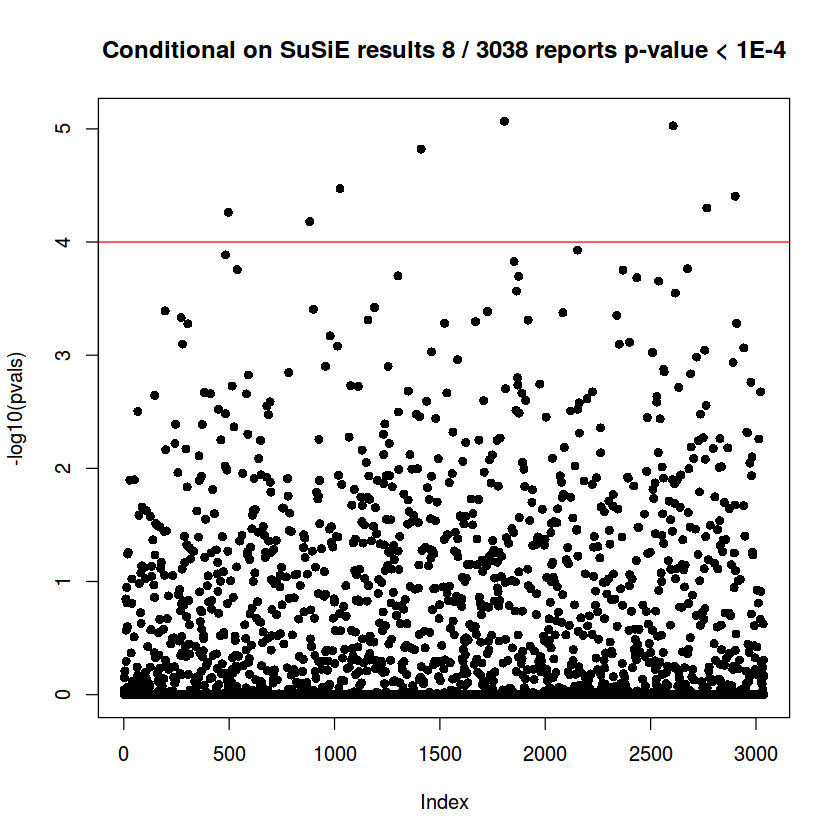

In [2]:
%preview JointLCL/AS_output/fastqtl_qqnorm_ASintron_RNAseqGeuvadis_YangVCF_100Kb/lm_follow_up/top_cond_pval.png

## Enrichment analysis

### Download and pre-process annotation data

Pipelines below were used to obtain and pre-process the annotation data-sets. We provide [here](https://shiny.stephenslab.uchicago.edu/) the processed annotation files for easier access.

#### Histone marks & DNase I hypersensitive site

```
sos run analysis/20180712_Enrichment_Workflow.ipynb download_histone_annotation --trait AS \
    --y-data $ydata
```

#### CTCF binding

```
sos run analysis/20180712_Enrichment_Workflow.ipynb download_ctcf_annotation --trait AS \
    --y-data $ydata
```

#### RNA polymerase II binding

```
sos run analysis/20180712_Enrichment_Workflow.ipynb download_polII_annotation --trait AS \
    --y-data $ydata
```

#### Gene regions

```
sos run analysis/20180712_Enrichment_Workflow.ipynb gene_regions --trait AS \
    --y-data $ydata
```

#### Extended splice sites

```
sos run analysis/20180712_Enrichment_Workflow.ipynb extended_splice_site --trait AS \
    --y-data $ydata
```

### Extract SuSiE summary statistics

We consolidate PIP and CS from identified sQTLs:

```
sos run analysis/20180712_Enrichment_Workflow.ipynb extract_sumstats \
    --y-data $ydata \
    --trait AS -j 16 
```

### Apply annotations

```
sos run analysis/20180712_Enrichment_Workflow.ipynb range2var_annotation \
    --y-data $ydata \
    --trait AS -j 16 \
    --single-annot $annotation_list
```

### Select candidate SNPs for sQTL enrichment analysis

Instead of performing matched analysis (matching MAF, distance to TSS, LD pattern) for other molecular genotypes, we focus on SNPs in genes for sQTL, as suggested by Li et al 2016.

```
sos run analysis/20180712_Enrichment_Workflow.ipynb overlap_cluster \
    --y-data $ydata \
    --trait AS
```

### Fisher's exact test for enrichment

```
sos run analysis/20180712_Enrichment_Workflow.ipynb cs_fisher_test \
    --y-data $ydata \
    --trait AS -j 16 \
    --single-annot $annotation_list
```

%preview JointLCL/AS_output/fastqtl_qqnorm_ASintron_RNAseqGeuvadis_YangVCF_100Kb/enrichment/SuSiE_loci.sumstats.cs_fisher_test.png

> JointLCL/AS_output/fastqtl_qqnorm_ASintron_RNAseqGeuvadis_YangVCF_100Kb/enrichment/SuSiE_loci.sumstats.cs_fisher_test.png (318.5 KiB):

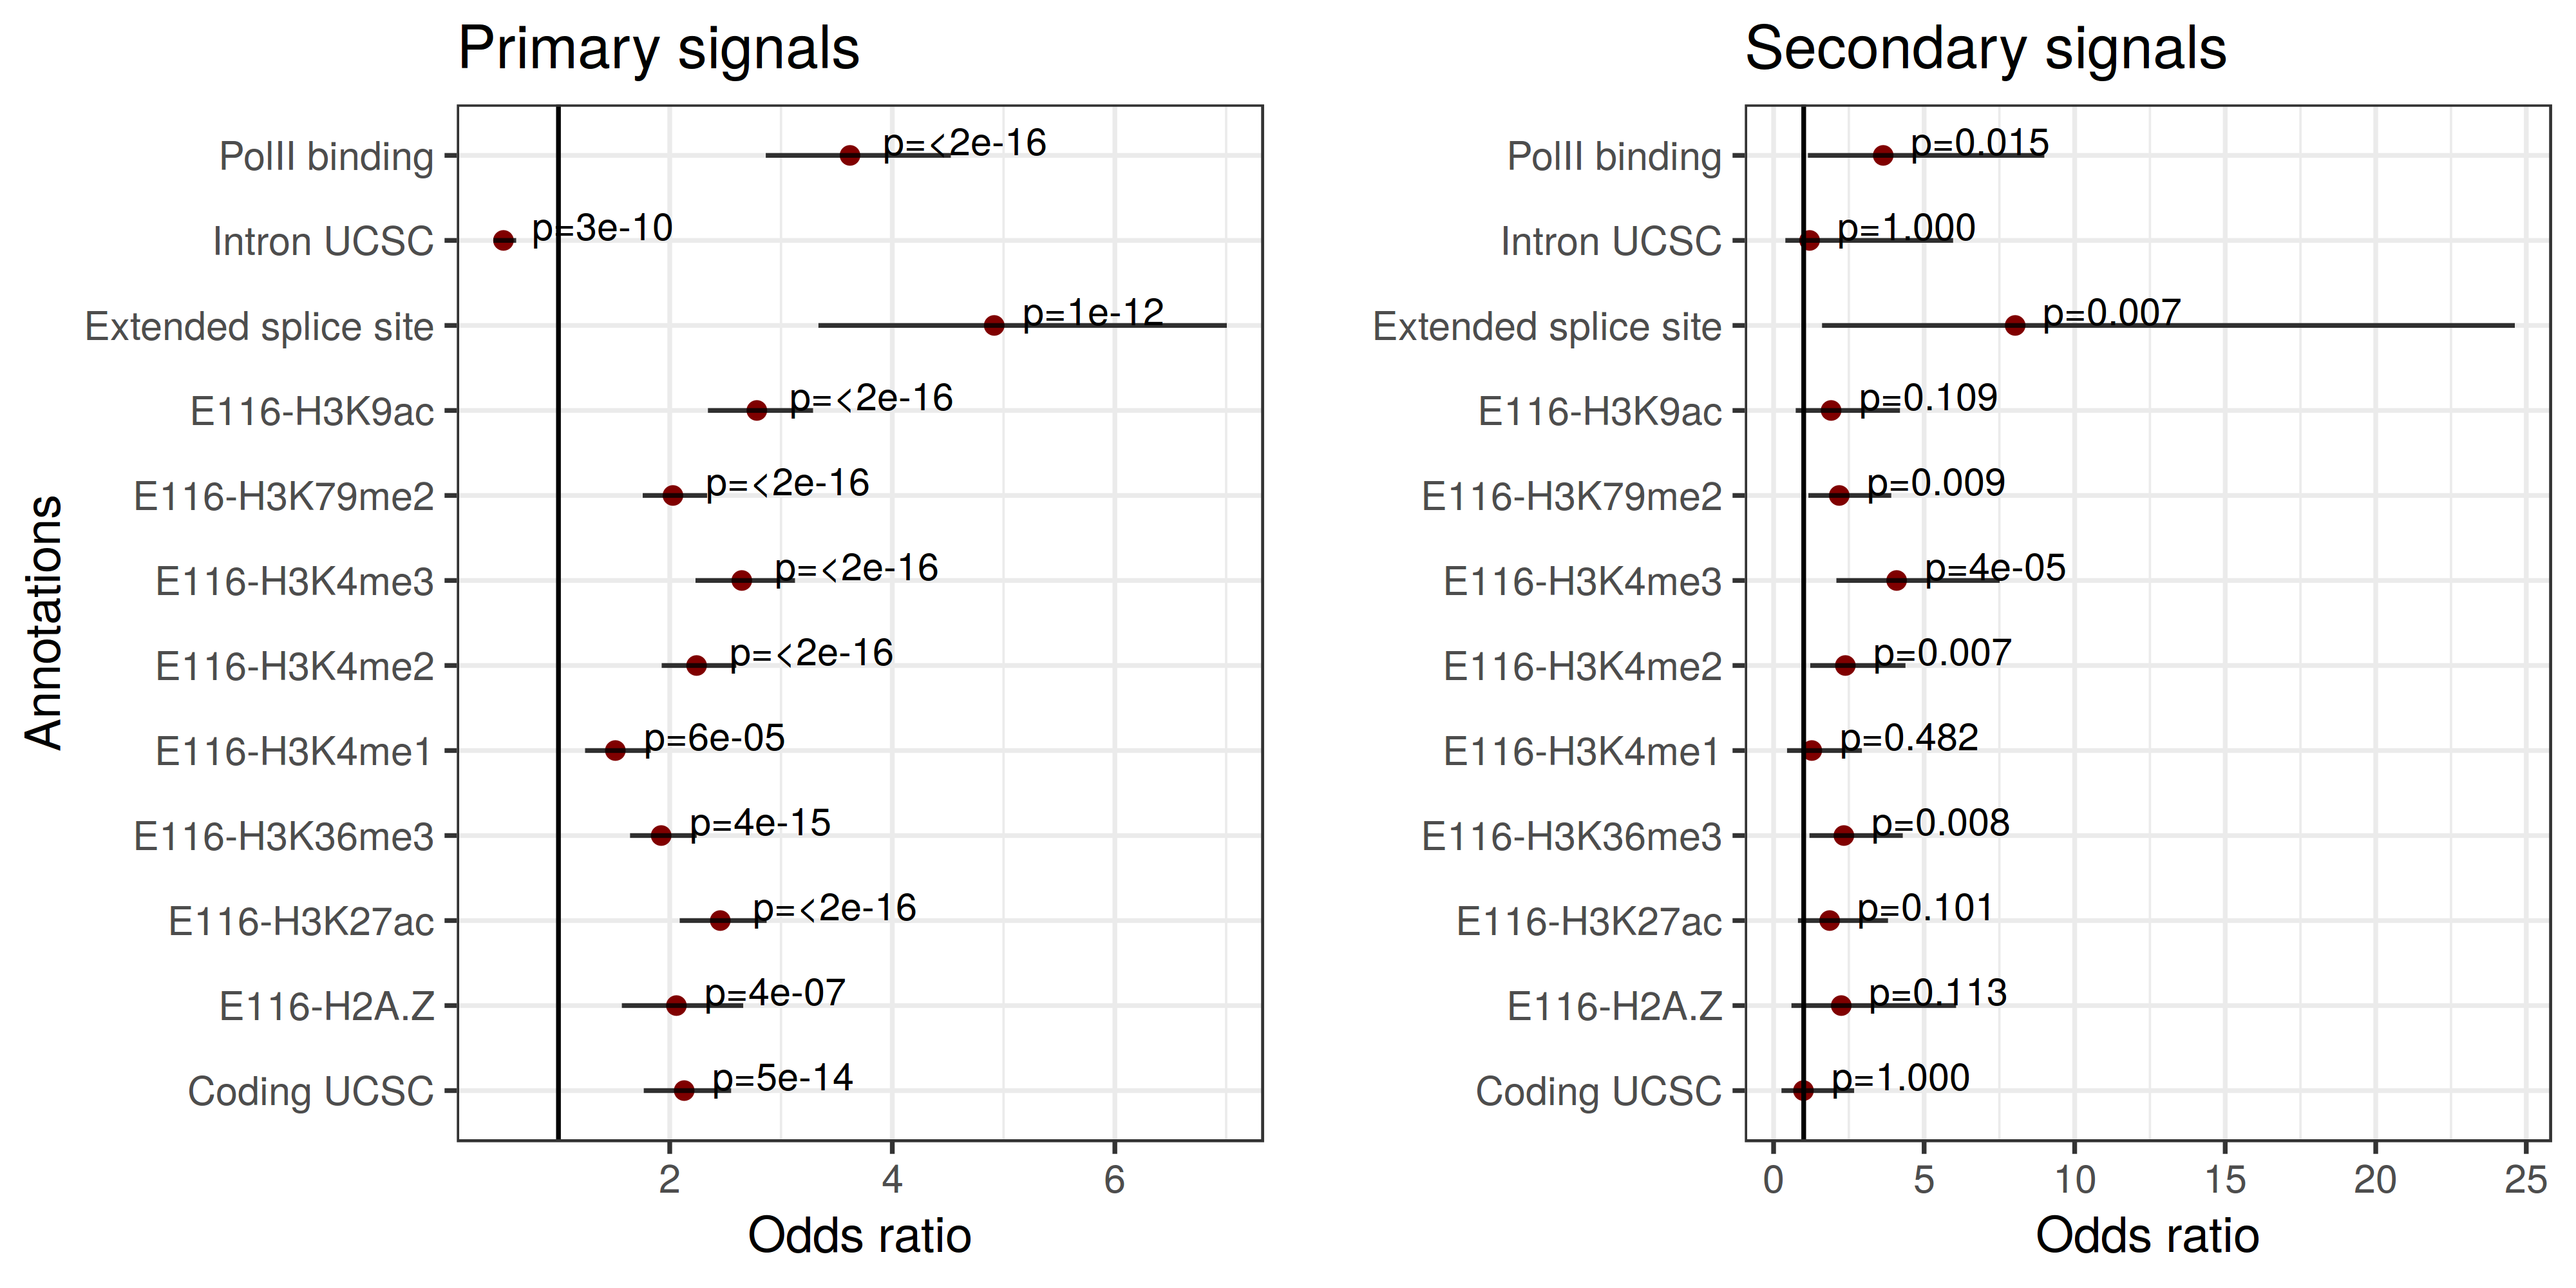

In [3]:
%preview JointLCL/AS_output/fastqtl_qqnorm_ASintron_RNAseqGeuvadis_YangVCF_100Kb/enrichment/SuSiE_loci.sumstats.cs_fisher_test.png